# Benchmark Modell 2 with SPG

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../..')
from helper.lazy_regression import TooLazyForRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import WLS

pd.options.display.max_columns = None

In [2]:
data = pd.read_table('../../data/data_spg.txt', sep=' ')
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [3]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
X,y = data[feature_cols], data['size_mm']
X.head(2)

,packnr,velocity,centroid_frequency_G01,centroid_frequency2_G01,centroid_frequency_G02,centroid_frequency2_G02,median_freq_G01,median_freq_G02,flash_ind_G01,flash_ind_G02,cv_G01,cv_G02,iqa_G01,iqa_G02,mab_G01,mab_G02,imp_G01,imp_G02,len_G01,len_G02
0,22,3.2,1862.480818,1782.582314,2165.858340,1920.629974,1749.839545,1909.190918,0.004357,0.003028,0.975134,1.167320,1.726607e-08,4.735567e-07,0.004644,0.027002,0,1,37,37
1,52,2.8,671.434928,457.188394,663.246762,462.475105,488.919882,497.205196,0.003794,0.002613,2.072236,1.768962,1.319711e-07,3.123975e-07,0.011466,0.020098,0,0,37,37


In [4]:
data.shape

(52463, 22)

## Select Best Feature for Benchmark

In [5]:
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

In [6]:
best_feature_dict = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.94s/it]


In [7]:
tmp = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp['score'] = np.abs(tmp['score'])
tmp.head(2)

,n_feature,score
0,1,0.606936
1,1,0.593029


In [8]:
tmp_ = tmp.groupby('n_feature').mean()

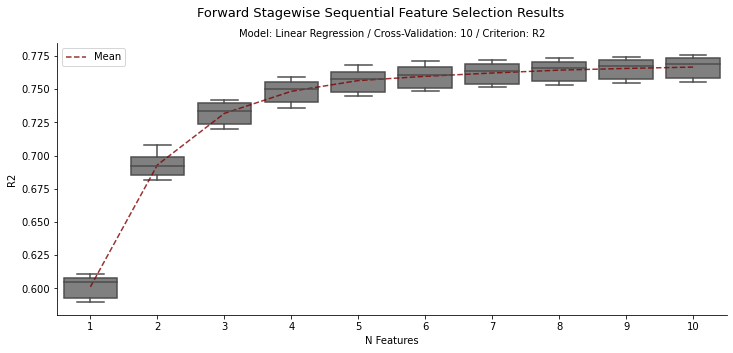

In [9]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp['n_feature'], y=tmp['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [10]:
n_features = 4
best_feature_dict[n_features]

array(['centroid_frequency_G01', 'centroid_frequency_G02',
       'centroid_frequency2_G02', 'imp_G01'], dtype=object)

In [11]:
X_best = X[best_feature_dict[n_features]]

## Hyperparameter 

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.7563679  0.74743726 0.73704942 0.75938634 0.75459906 0.7482335
 0.73819694 0.75229274 0.7553658  0.73569231]
Mean Resutls:  0.7484621268712873


## With Max-Feature

In [14]:
from helper.feature_extract import extract_highest_amplitude_features_with_mp

In [15]:
df_max = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['G01', 'G02']],
                                                  create_one_sensor_feature=True, n_processes=4, 
                                                  keep_columns=False)

INFO || Extracting Max Features for types: ['G01', 'G02']


In [16]:
feature_cols = df_max.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')

In [17]:
X,y = df_max[feature_cols], df_max['size_mm']
X.head(2)

,packnr,velocity,max_centroid_frequency_G,max_centroid_frequency2_G,max_median_freq_G,max_flash_ind_G,max_cv_G,max_iqa_G,max_mab_G,max_imp_G,max_len_G
0,22,3.2,2165.858340,1920.629974,1909.190918,0.003028,1.167320,4.735567e-07,0.027002,1,37
1,52,2.8,663.246762,462.475105,497.205196,0.002613,1.768962,3.123975e-07,0.020098,0,37


In [18]:
df_max.shape

(52463, 13)

In [19]:
best_feature_dict_max = {}
best_feature_cvscores = {}
for n_features in tqdm(np.arange(1,10+1)):
    select = SequentialFeatureSelector(estimator=LinearRegression(), 
                                       n_features_to_select=n_features, 
                                       direction='forward', 
                                       scoring='r2')
    select.fit(X, np.log(y))
    best_col = X.columns.to_numpy()[select.get_support()]
    best_feature_dict_max[n_features] = best_col
    best_feature_cvscores[n_features] = cross_val_score(estimator=LinearRegression(),
                                                        X=X[best_col], 
                                                        y=np.log(y), cv=10, 
                                                        scoring='r2')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


In [20]:
tmp_max = pd.melt(pd.DataFrame.from_dict(best_feature_cvscores), var_name='n_feature', value_name='score')
tmp_max['score'] = np.abs(tmp_max['score'])
tmp_ = tmp_max.groupby('n_feature').mean()

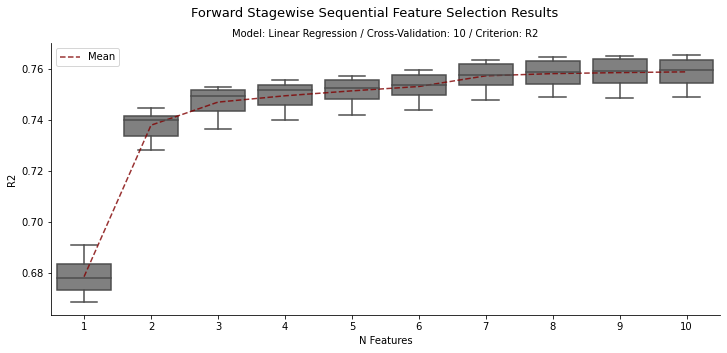

In [21]:
fig = plt.subplots(figsize=(12, 5))
p = sns.boxplot(x=tmp_max['n_feature'], y=tmp_max['score'], color='grey')
p1 = sns.lineplot(x=tmp_.index-1, y=tmp_.to_numpy().reshape(-1), color='maroon', 
                  linestyle='--', label='Mean', alpha=.8)
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
plt.show()

In [22]:
n_features = 3
best_feature_dict_max[n_features]

array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_imp_G'],
      dtype=object)

In [23]:
X_best = X[best_feature_dict_max[n_features]]

In [24]:
results = cross_val_score(estimator=LinearRegression(), X=X_best, y=np.log(y), cv=10)
print('CV Results:\n', results)
print('Mean Resutls: ', np.mean(results))

CV Results:
 [0.75037323 0.7480023  0.74174721 0.75272947 0.75194675 0.75200336
 0.73701453 0.74954223 0.74912934 0.73658604]
Mean Resutls:  0.7469074451081681


## Max vs. normal

In [28]:
sns.set_style('whitegrid')

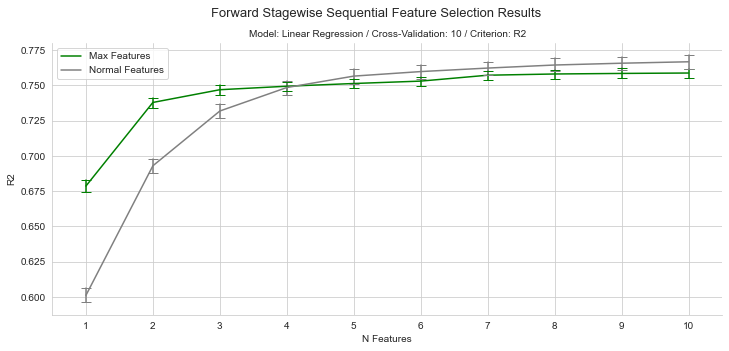

In [29]:
fig = plt.subplots(figsize=(12, 5))
p = sns.lineplot(data=tmp_max, x='n_feature', y='score', 
                 ci=95, err_style='bars', label='Max Features', 
                 color='green', err_kws={'capsize':5})
p2 = sns.lineplot(data=tmp, x='n_feature', y='score', 
                  ci=95, err_style='bars', label='Normal Features', 
                  color='grey', err_kws={'capsize':5})
plt.title(r'Model: Linear Regression / Cross-Validation: 10 / Criterion: R2', fontsize=10)
plt.suptitle('Forward Stagewise Sequential Feature Selection Results', fontsize=13)
plt.xlabel('N Features')
plt.ylabel(r'R2')
sns.despine()
p.set_xticks(tmp_max.n_feature.unique())
p.set_xlim(.5, 10.5)
plt.show()

In [50]:
unpack_list = lambda *args: np.array([i for i in args])

In [51]:
F = [unpack_list(*v) for k, v in best_feature_dict.items()]

In [52]:
np.array(F).flatten()

array([array(['centroid_frequency_G01'], dtype='<U22'),
       array(['centroid_frequency_G01', 'centroid_frequency_G02'], dtype='<U22'),
       array(['centroid_frequency_G01', 'centroid_frequency_G02', 'imp_G01'],
             dtype='<U22')                                                   ,
       array(['centroid_frequency_G01', 'centroid_frequency_G02',
              'centroid_frequency2_G02', 'imp_G01'], dtype='<U23'),
       array(['centroid_frequency_G01', 'centroid_frequency2_G01',
              'centroid_frequency_G02', 'centroid_frequency2_G02', 'imp_G01'],
             dtype='<U23')                                                    ,
       array(['centroid_frequency_G01', 'centroid_frequency2_G01',
              'centroid_frequency_G02', 'centroid_frequency2_G02', 'mab_G02',
              'imp_G01'], dtype='<U23')                                      ,
       array(['centroid_frequency_G01', 'centroid_frequency2_G01',
              'centroid_frequency_G02', 'centroid_freq

In [27]:
best_feature_dict_max

{1: array(['max_centroid_frequency_G'], dtype=object),
 2: array(['max_centroid_frequency_G', 'max_imp_G'], dtype=object),
 3: array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_imp_G'],
       dtype=object),
 4: array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_mab_G',
        'max_imp_G'], dtype=object),
 5: array(['max_centroid_frequency_G', 'max_flash_ind_G', 'max_iqa_G',
        'max_mab_G', 'max_imp_G'], dtype=object),
 6: array(['max_centroid_frequency_G', 'max_centroid_frequency2_G',
        'max_flash_ind_G', 'max_iqa_G', 'max_mab_G', 'max_imp_G'],
       dtype=object),
 7: array(['max_centroid_frequency_G', 'max_centroid_frequency2_G',
        'max_median_freq_G', 'max_flash_ind_G', 'max_iqa_G', 'max_mab_G',
        'max_imp_G'], dtype=object),
 8: array(['max_centroid_frequency_G', 'max_centroid_frequency2_G',
        'max_median_freq_G', 'max_flash_ind_G', 'max_iqa_G', 'max_mab_G',
        'max_imp_G', 'max_len_G'], dtype=object),
 9: array(['packnr', 'max_